## Simple toy model

This run generates an artificial (i.e.) unphysical set of halos and evolves them following perfect exponential growth. The distribution of halos is used to paint a grid and compute the corresponding signal and their evolution over a few redshift snapshots. The remaining parameters are unphysical as well and chosen for illustration purposes.

**NOTE:**
- running this notebook will store output files in the current working directory:
- cache files (intermediate computations) are stored under `./cache`
- final files (the resulting grid data) are stored under `./output`

Make sure to change these paths below.

In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
# Change the output of the computatiojs
FILE_ROOT = Path(".")
CACHE_ROOT = FILE_ROOT / "cache"
OUTPUT_ROOT = FILE_ROOT / "output"

In [ ]:
import beorn

In [ ]:
parameters = beorn.structs.Parameters()

# Halo Mass bins
parameters.simulation.halo_mass_bin_min = 1e7
parameters.simulation.halo_mass_bin_max = 1e15
parameters.simulation.halo_mass_bin_n = 200

parameters.simulation.Lbox = 100
parameters.simulation.Ncell = 128

# Nbr of cores to use
parameters.simulation.cores = 5


# cosmo
parameters.cosmology.Om = 0.31
parameters.cosmology.Ob = 0.045
parameters.cosmology.Ol = 0.69
parameters.cosmology.h = 0.68

# Source parameters
# lyman-alpha
parameters.simulation.halo_mass_accretion_alpha = np.array([0.785, 0.795])
parameters.source.n_lyman_alpha_photons = 9690*10  # 1500
parameters.source.lyman_alpha_power_law = 0.0
# ion
parameters.source.Nion = 5000 * 3
# xray
parameters.source.energy_cutoff_min_xray = 500
parameters.source.energy_cutoff_max_xray = 2000
parameters.source.energy_min_sed_xray = 500
parameters.source.energy_max_sed_xray = 2000
parameters.source.alS_xray = 1.5
parameters.source.xray_normalisation = 3.4e40 * 3

# fesc
parameters.source.f0_esc = 0.2
parameters.source.pl_esc = 0

# fstar
parameters.source.f_st = 1
parameters.source.g1 = 0
parameters.source.g2 = 0

parameters.source.g3 = 4
parameters.source.g4 = -1
parameters.source.Mp = 1.6e11 * parameters.cosmology.h
parameters.source.Mt = 1e7

# Minimum star forming halo
parameters.source.halo_mass_min = 1e5


parameters.simulation.store_grids = ['Tk','bubbles','lyal', 'Grid_dTb']

In [ ]:
cache_handler = beorn.io.Handler(CACHE_ROOT)
loader = beorn.load_input_data.ArtificialHaloLoader(
    parameters,
    halo_count = 100,
)

17:44:43 - INFO - handler.py - Using persistence directory at .plotting and kwargs None


In [ ]:
try:
    profiles = cache_handler.load_file(parameters, beorn.structs.RadiationProfiles)
except FileNotFoundError:
    s = beorn.radiation_profiles.ProfileSolver(parameters, cache_handler, loader.redshifts)
    profiles = s.solve()

    # since we want to skip recalculating the profiles, we save them
    cache_handler.write_file(parameters, profiles)

17:44:43 - INFO - solver.py - param.solver.fXh is set to constant. We will assume f_X,h = 2e-4**0.225
17:44:43 - INFO - solver.py - Computing profiles for 38 redshifts, 199 halo mass bins and 1 alpha bins.


17:44:49 - WARNING - base_struct.py - Field Tk not found in RadiationProfiles. It will not be written to the HDF5 file.
17:44:49 - WARNING - base_struct.py - Field bubbles not found in RadiationProfiles. It will not be written to the HDF5 file.
17:44:49 - WARNING - base_struct.py - Field lyal not found in RadiationProfiles. It will not be written to the HDF5 file.
17:44:49 - WARNING - base_struct.py - Field Grid_dTb not found in RadiationProfiles. It will not be written to the HDF5 file.
17:44:49 - INFO - base_struct.py - Data written to .plotting/RadiationProfiles_db7a2ba19daaf0b9cb026ba418579de5_.h5 (80.98 MB)


17:44:49 - INFO - halo_catalog.py - No alpha values provided, using default value of 0.79 for all halos.


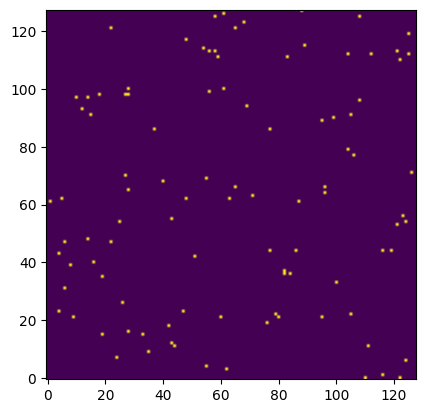

In [ ]:
halo_catalog = loader.load_halo_catalog(9)

mesh = halo_catalog.to_mesh()
stacked_mesh = np.sum(mesh, axis=0)

plt.figure()
plt.imshow(stacked_mesh, origin='lower', cmap='viridis')
plt.show()


In [ ]:
output_handler = beorn.io.Handler(OUTPUT_ROOT)

p = beorn.painting.Painter(
    parameters,
    loader = loader,
    cache_handler = cache_handler,
    output_handler = output_handler
)

multi_z_quantities = p.paint_full(profiles)

17:44:49 - INFO - handler.py - Using persistence directory at .plotting/output and kwargs None
17:44:49 - INFO - painter.py - Painting profiles onto grid for 38 redshift snapshots. Using 5 processes.


Painting redshift snapshots:   0%|          | 0/38 [00:00<?, ?snapshot/s]

17:44:49 - INFO - halo_catalog.py - No alpha values provided, using default value of 0.79 for all halos.
17:44:49 - INFO - painter.py - Painting 100 halos at zgrid=24.50 (z_index=0).
17:44:52 - INFO - painter.py - painted total_halos=100 with initially halo_catalog.size=100 halos.
17:44:52 - INFO - painter.py - Profile painting took 0:00:02.621396.
17:44:52 - INFO - spread_old.py - Universe not fully ionized : xHII is 0.0.
17:44:52 - INFO - painter.py - Redistributing excess photons from the overlapping regions took 0:00:00.149064.
17:44:52 - INFO - painter.py - Postprocessing of the grids took 0:00:00.092145.
17:44:52 - INFO - painter.py - Current snapshot took 0:00:02.873108.
17:44:52 - WARNING - base_struct.py - Field Tk not found in GridData. It will not be written to the HDF5 file.
17:44:52 - WARNING - base_struct.py - Field bubbles not found in GridData. It will not be written to the HDF5 file.
17:44:52 - WARNING - base_struct.py - Field lyal not found in GridData. It will not be

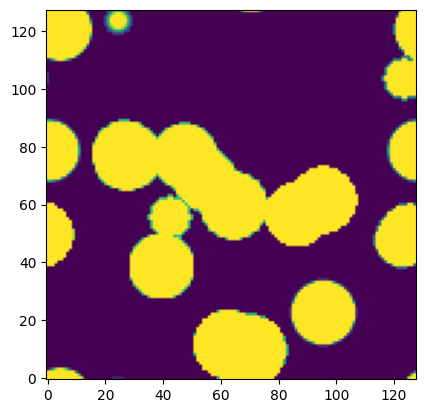

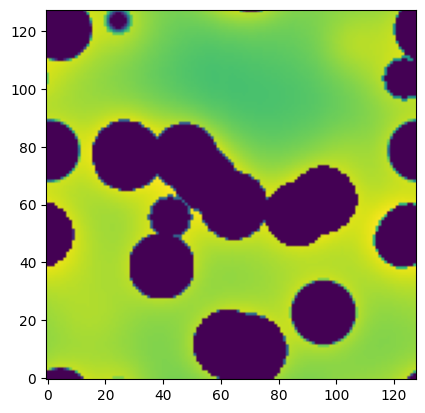

In [ ]:
z = 9
z_index = np.argmin(np.abs(loader.redshifts - z))

xHII_grid = multi_z_quantities.Grid_xHII[z_index, ...]
plt.figure()
plt.imshow(xHII_grid[:, 64, :], origin='lower', cmap='viridis')
plt.show()

dTb_grid = multi_z_quantities.Grid_dTb[z_index, ...]
plt.figure()
plt.imshow(dTb_grid[:, 64, :], origin='lower', cmap='viridis')
plt.show()

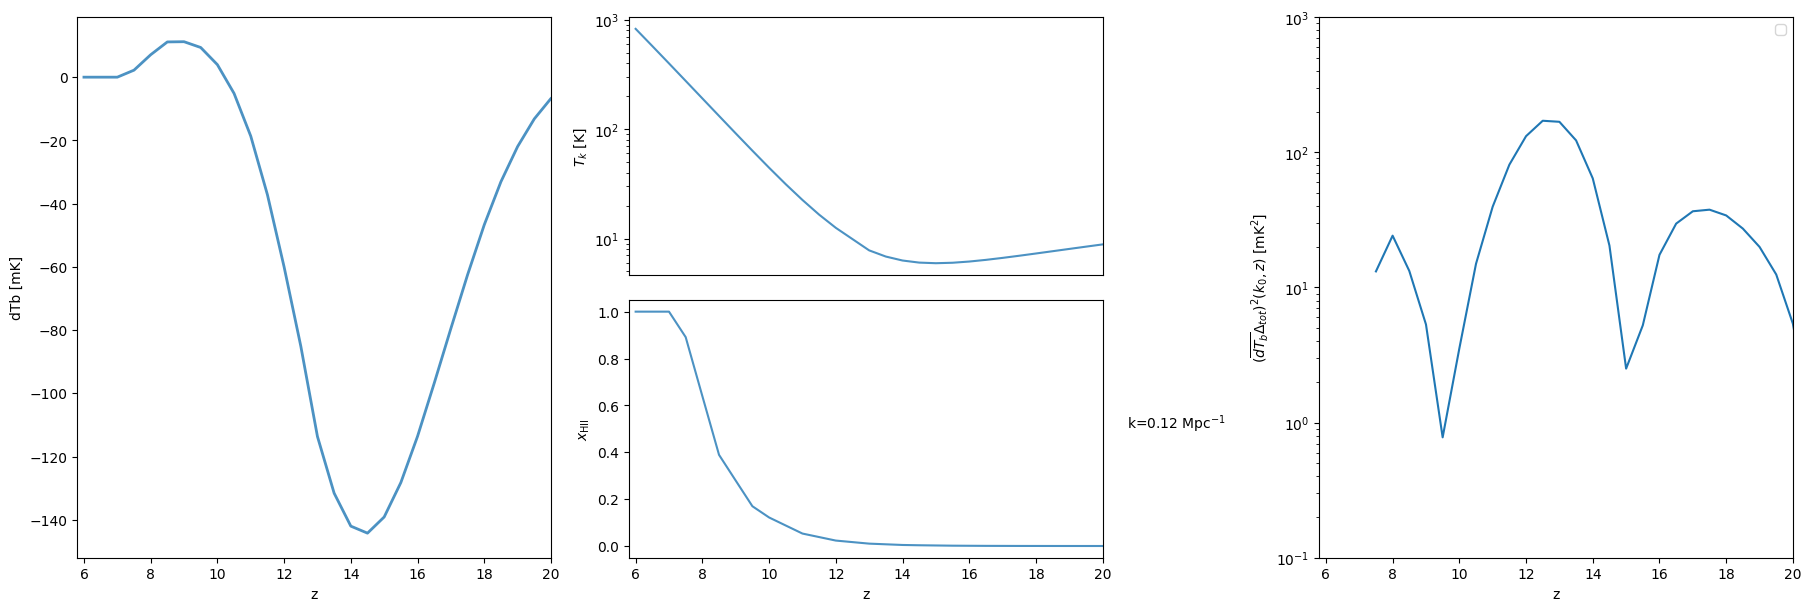

In [ ]:
# Set up the figure and axes
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(18)
fig.set_figheight(6)
gs = gridspec.GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,1], sharex=ax2)
ax4 = fig.add_subplot(gs[:,2])

# Plot for each grid data that is available

beorn.plotting.draw_dTb_signal(ax1, multi_z_quantities)
beorn.plotting.draw_Temp_signal(ax2, multi_z_quantities)
beorn.plotting.draw_xHII_signal(ax3, multi_z_quantities)
beorn.plotting.draw_dTb_power_spectrum_of_z(ax4, multi_z_quantities, parameters)

ax4.legend(loc='best')
ax2.axes.get_xaxis().set_visible(False)
plt.show()

Making lightcone between 0.039216 < z < 0.142703


100%|██████████| 547/547 [00:00<00:00, 766.91it/s]


...done


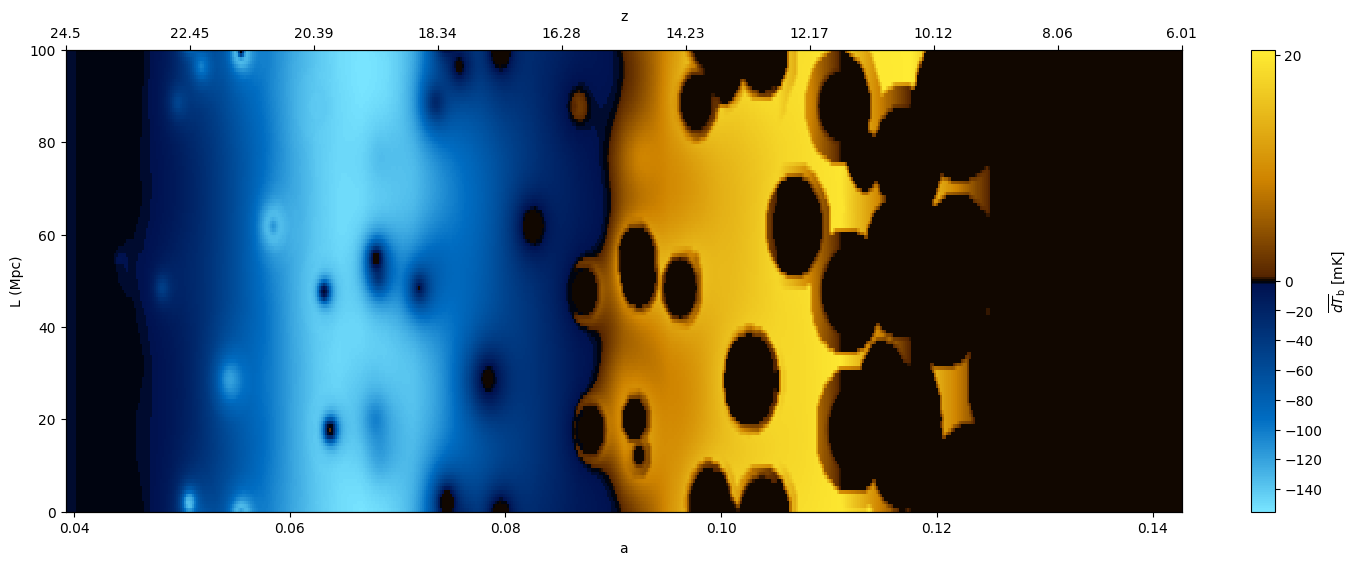

In [ ]:
lightcone = beorn.structs.Lightcone.build(
    parameters,
    multi_z_quantities,
    quantity = "Grid_dTb",
)

fig, ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(6)
beorn.plotting.plot_lightcone(lightcone, ax, "", slice_number=80)
fig.show()